In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import data_manager.utils as sbtu
import data_manager.scanner as scanner
import regime as sur
import scripts
# import src.floor_ceiling_regime

In [2]:
(
    _price_data,
    _bench,
    _strategy_overview,
    _peak_table,
    _entry_table,
    _strategy_lookup
) = scripts.load_data_package()
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:>

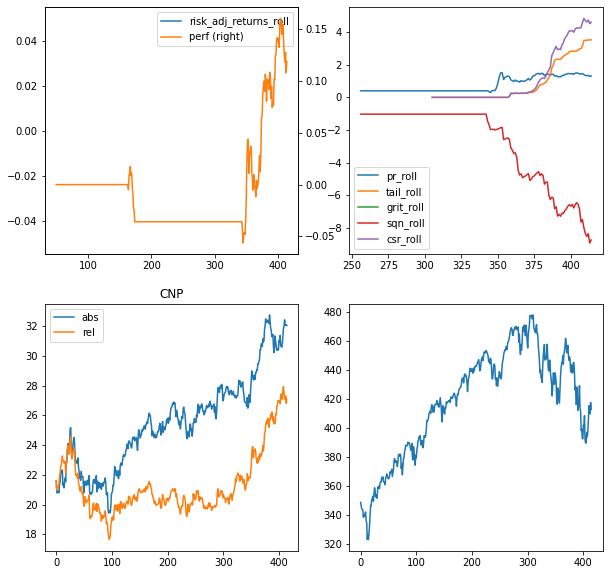

In [3]:
symbol = 'CNP'
_strat_data = _strategy_lookup[symbol]
_stats = _strategy_lookup[symbol].stat_historical
_, axs = plt.subplots(2, 2)
_stats[['risk_adj_returns_roll', 'perf']].plot(secondary_y=['perf'], ax=axs[0, 0], figsize=[10,10])
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(ax=axs[0, 1])

def get_abs_rel(_s):
    sd = _price_data_by_symbol.data[_s]
    rel = sur.simple_relative(sd, _bench.close).close
    return pd.DataFrame(
        data={
            'abs': sd.close,
            'rel': rel
        }
    )

_symbol_data = _price_data_by_symbol.data[symbol]
get_abs_rel(symbol).plot(title=symbol, ax=axs[1, 0])
_bench.close.plot(ax=axs[1, 1])

<AxesSubplot:xlabel='entry'>

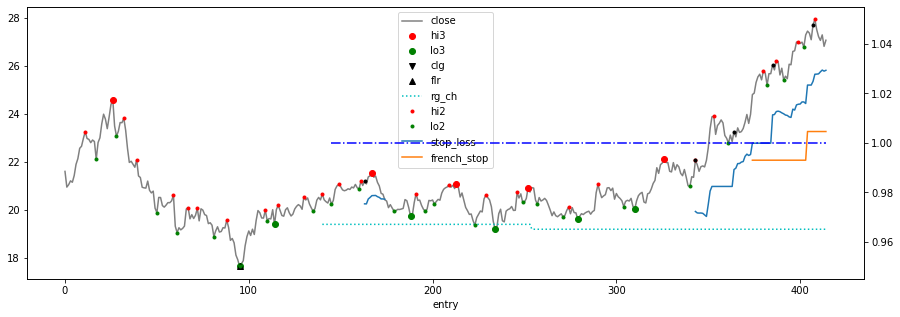

In [4]:
epd = _strategy_lookup[symbol].enhanced_price_data.copy()
epd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price
_sl = _strategy_lookup[symbol].stop_loss_series
_sl = _sl.loc[~_sl.index.duplicated(keep='first')]
epd['stop_loss'] = _sl
# epd['base_close'] = _symbol_data.close
scanner.enhanced_price_data_plot(epd)
_en_cpy = _entry_table.loc[_entry_table.symbol == symbol].copy()
_en_cpy.index = _en_cpy.entry
_en_cpy.en_px.plot(style='k.')

In [5]:

_pt = _strategy_lookup[symbol].peak_table.copy()
# _pt = pda.PeakTable(_pt)
# _pt = _pt.unpivot(_symbol_data.index)
# _pt = _pt.loc[~_pt.index.duplicated(keep='first')]
def filter_duplicates(_sw):
    return _sw.loc[~_sw.index.duplicated(keep='first')]

_shi_px = _pt.loc[(_pt.type == -1)].set_index('end')
_slo_px = _pt.loc[(_pt.type == 1)].set_index('end')
_shis = []
_slos = []
for i in range(1, 5):
    _shis.append(
        _shi_px.loc[(_shi_px.lvl == i)]
    )
    _shis[i-1] = filter_duplicates(_shis[i-1])
    _slos.append(
        _slo_px.loc[(_slo_px.lvl == i)]
    )
    _slos[i-1] = filter_duplicates(_slos[i-1])
    epd[f'hi{i}_lag'] = _shis[i-1].en_px
    epd[f'lo{i}_lag'] = _slos[i-1].en_px


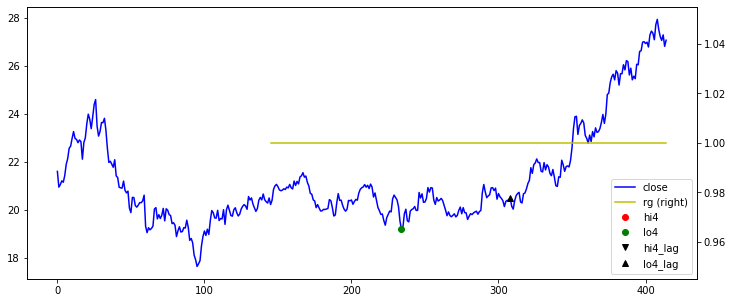

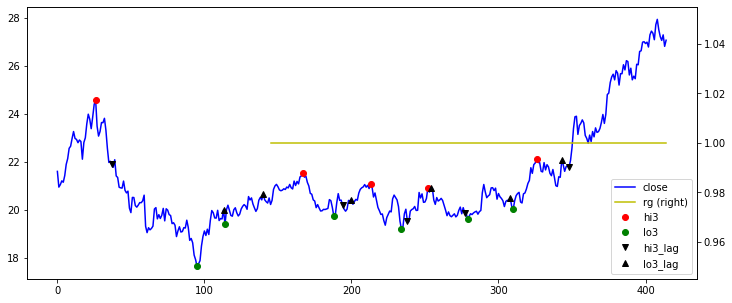

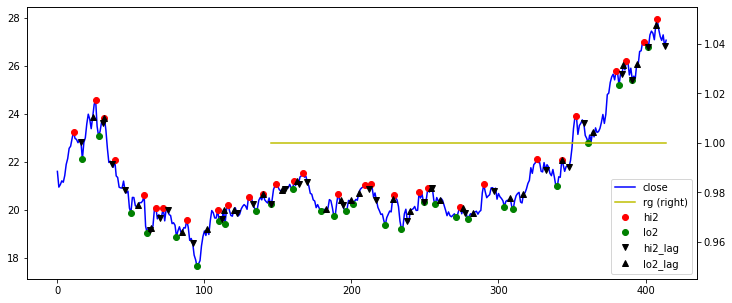

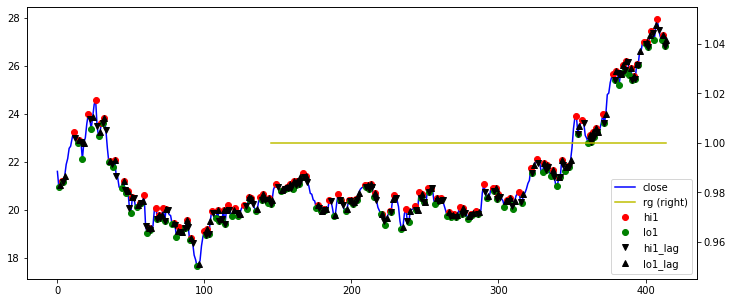

In [6]:


_epd_plt = epd[['close', 'hi2', 'lo2', 'hi3', 'lo3', 'rg']]

def plot(lvl):
    epd[[
        'close', 'rg',
        f'hi{lvl}', f'lo{lvl}',
        f'hi{lvl}_lag', f'lo{lvl}_lag',
    ]].plot(style=['b', 'y', 'ro', 'go', 'kv', 'k^'], figsize=[12, 5], secondary_y='rg')

plot(4)
plot(3)
plot(2)
plot(1)

<AxesSubplot:title={'center':'lvl3 lag'}, ylabel='Frequency'>

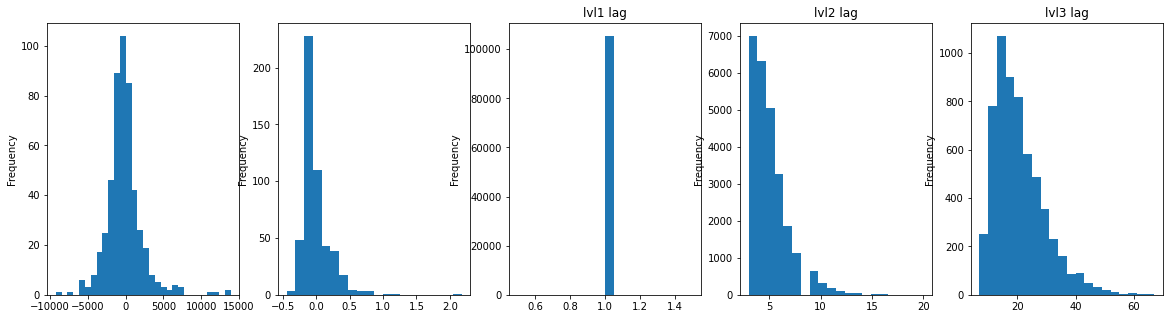

In [7]:
_, axs = plt.subplots(1, 5)
_strategy_overview.weight_total.plot.hist(bins=30, ax=axs[0], figsize=(20, 5))
_strategy_overview.perf.plot.hist(bins=20, ax=axs[1])

_peak_table['peak_lag'] = _peak_table.end - _peak_table.start
partial_exit_lag = _entry_table.partial_exit_date - _entry_table.entry
_entry_table['partial_exit_lag'] = partial_exit_lag

_peak_table.loc[_peak_table.lvl == 1, 'peak_lag'].plot.hist(bins=20, ax=axs[2], title='lvl1 lag')
_peak_table.loc[_peak_table.lvl == 2, 'peak_lag'].plot.hist(bins=20, ax=axs[3], title='lvl2 lag')
_peak_table.loc[_peak_table.lvl == 3, 'peak_lag'].plot.hist(bins=20, ax=axs[4], title='lvl3 lag')

,entry,en_px,st_px,dir,trail_stop,fixed_stop,fixed_stop_price,r_pct,target_price,partial_exit_date,...,partial_exit,risk,shares,partial_profit,rem_profit,partial_total,no_partial_total,my_total,total,partial_exit_lag
0,213.0,156.681095,158.359875,-1.0,209.0,190.0,162.467078,-0.036928,148.002122,227.0,...,185.580002,-0.007500,-38.0,349.250031,690.755127,1040.005157,2019.130371,1040.005157,1040.005157,14.0
1,248.0,143.018559,145.156909,-1.0,243.0,243.0,145.156909,-0.014952,139.811034,260.0,...,180.800003,-0.005303,-74.0,-117.600449,799.625015,682.024567,2366.890045,682.024567,1722.029724,12.0
2,262.0,139.287856,142.267897,-1.0,255.0,255.0,142.267897,-0.021395,134.817794,279.0,...,178.770004,-0.004330,-43.0,94.919983,536.175156,631.095139,1537.035446,631.095139,2353.124863,17.0
3,294.0,131.166958,134.659414,-1.0,290.0,290.0,134.659414,-0.026626,125.928272,NaN,...,NaN,-0.003750,-32.0,NaN,-15.179886,NaN,-44.159668,-44.159668,2308.965195,NaN
4,351.0,118.372614,119.874318,-1.0,346.0,346.0,119.874318,-0.012686,116.120059,364.0,...,147.679993,-0.003354,-67.0,-41.799866,-172.5,-214.299866,-502.5,-214.299866,2094.665329,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,356.0,53.292728,51.728189,1.0,352.0,352.0,51.728189,0.029357,55.639536,NaN,...,NaN,-0.005303,102.0,NaN,-3.740021,NaN,-11.220062,-11.220062,-693.500153,NaN
0,179.0,153.243641,152.040308,1.0,176.0,176.0,152.040308,0.007852,155.048639,183.0,...,194.020004,-0.007500,187.0,753.749847,85.559357,839.309204,258.05806,839.309204,839.309204,4.0
1,203.0,161.303467,158.758018,1.0,197.0,197.0,158.758018,0.015781,165.121642,278.0,...,221.869995,-0.005303,63.0,746.339539,-345.240051,401.099487,-1035.720154,401.099487,1240.408691,75.0
2,284.0,166.60227,161.15536,1.0,276.0,276.0,161.15536,0.032694,174.772635,299.0,...,234.309998,-0.004330,24.0,239.839844,-98.560059,141.279785,-295.680176,141.279785,1381.688477,15.0


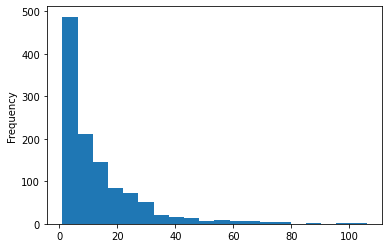

In [8]:
partial_exit_lag.plot.hist(bins=20)
_entry_table